In [1]:
from sklearn.decomposition import NMF, FastICA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, cross_val_predict
import tensorly as tl
from tensorly.decomposition import non_negative_parafac, parafac, non_negative_tucker, tucker
from tensorly.tenalg import khatri_rao
import os
import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
import warnings
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [4]:
mat=scipy.io.loadmat(r'C:\Users\bsdor\OneDrive - University of Leeds\Data_analysis\EEGData.mat')
stim=mat['stim']
mat=mat['EEGData']

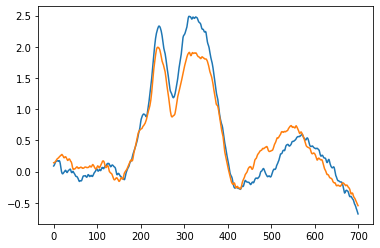

In [5]:
## Question 1) a)
#Plot the trial-averaged response of 
#EEG channel 60 to face stimuli. Compare it with the response of the same channel to car stimuli.. 

##Answer

    #Extract face stimuli trials using conditional indexing
face_trials=mat[:,:,np.where(stim==1)[1]]
    #plot output averaged across trials
plt.plot(face_trials.mean(axis=2)[59,:].T)

car_trials=mat[:,:,np.where(stim==2)[1]]

    #plot output averaged across trials
plt.plot(car_trials.mean(axis=2)[59,:].T)

plt.show()

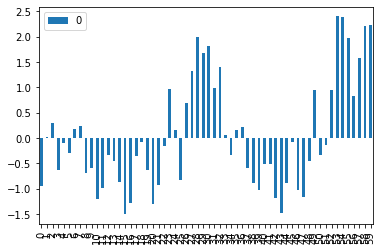

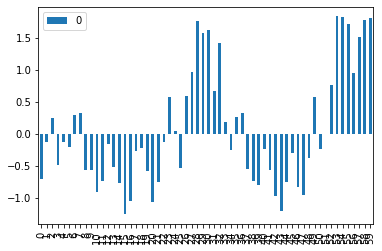

In [6]:
##Question b) Plot the trial-averaged response of all EEG channels at time point 350 to face stimuli. 
#Compare it with the response at the same timepoint to car stimuli.

#Face stimuli trials at timepoint 350 for all EEG channels
pd.DataFrame(face_trials[:,350,:].mean(axis=1).T).plot(kind='bar')

#Car stimuli trials at timepoint 350 for all EEG channels
car_trials=mat[:,:,np.where(stim==2)[1]]
pd.DataFrame(car_trials[:,350,:].mean(axis=1).T).plot(kind='bar')

plt.show()

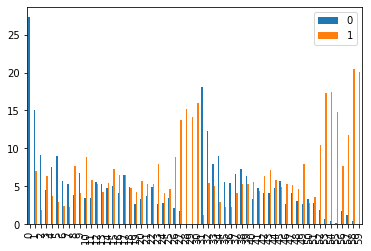

Timepoint specific activation coefficient : [[0.15416025 0.0872411  0.01994968 ... 0.06816854 0.08412154 0.05002533]
 [0.08700251 0.01426511 0.0499617  ... 0.05408759 0.10517579 0.07522034]]


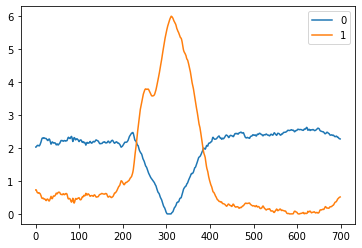

<AxesSubplot:>

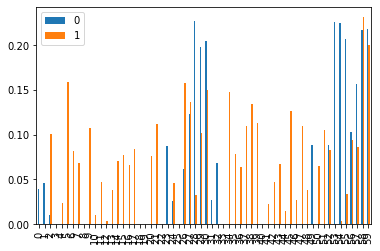

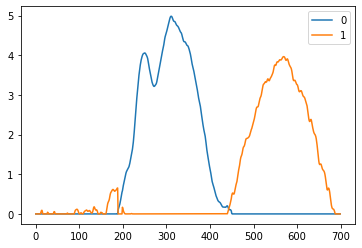

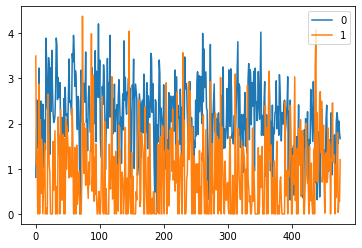

In [12]:
#Question 2) a) Using tensor and/or matrix decomposition techniques, extract and plot the two main temporal components 
#and the two main spatial components of EEG activity. 
#Justify your model choice with reference to alternative techniques.

#NNMF
model_NMF=NMF(n_components=2,solver='cd',
    beta_loss='frobenius',
    tol=0.0001,
    max_iter=200,
    random_state=None,
    alpha=0.0,
    l1_ratio=0.0,
    verbose=0,
    shuffle=False)

X=mat.reshape(60,700*477)
W_spatial = model_NMF.fit_transform(abs(X))
H_spatial = model_NMF.components_

pd.DataFrame(W_spatial).plot(kind='bar')
plt.show()
print('Timepoint specific activation coefficient :', H_spatial)


X_temp=mat.transpose(1,2,0).reshape(700,477*60)
model_NMF.fit(abs(X_temp))

X_pca=model_NMF.transform(abs(X_temp))

pd.DataFrame(X_pca).plot(kind='line')
plt.show()



#Non-negative parafac


factors_nnpara = non_negative_parafac(mat ,rank=2)

factors_nnpara[1]


pd.DataFrame(factors_nnpara[1][0]).plot(kind='bar')
pd.DataFrame(factors_nnpara[1][1]).plot()
pd.DataFrame(factors_nnpara[1][2]).plot()


Accuracy score for combined componentse:  0.65625


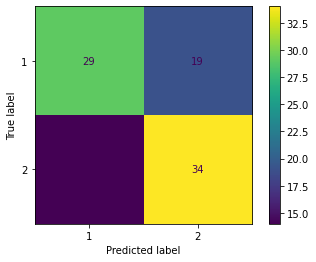

Accuracy score for ST1:  0.6458333333333334


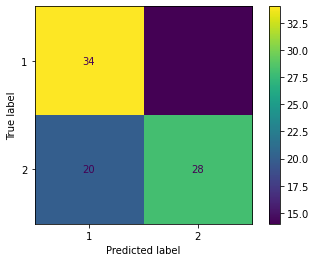

Accuracy score for ST2:  0.46875


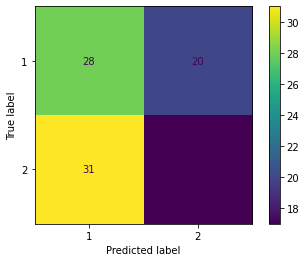

In [14]:
##Question b)   
##Use the extracted EEG components to discriminate which stimulus was presented on each trial.
##What is the discrimination accuracy?

X_train, X_test, y_train, y_test=train_test_split(factors_nnpara[1][2],stim.T,train_size=0.8,stratify=stim.T)
lda=LDA()
lda.fit(X_train,y_train)



results = lda.predict(X_test)
print('Accuracy score for combined componentse: ',accuracy_score(y_test,results))
plot_confusion_matrix(lda ,X_test,y_test)
plt.show()

##Which component or combination of components carry most of the discrimination power? 
##Illustrate this by plotting the corresponding confusion matrices. 

X_train, X_test, y_train, y_test=train_test_split(factors_nnpara[1][2][:,0].reshape(1,-1).T,stim.T,train_size=0.8,stratify=stim.T)
lda=LDA()
lda.fit(X_train,y_train)



results = lda.predict(X_test)
print('Accuracy score for ST1: ',accuracy_score(y_test,results))
plot_confusion_matrix(lda ,X_test,y_test)
plt.show()


X_train, X_test, y_train, y_test=train_test_split(factors_nnpara[1][2][:,1].reshape(1,-1).T,stim.T,train_size=0.8,stratify=stim.T)
lda=LDA()
lda.fit(X_train,y_train)



results = lda.predict(X_test)
print('Accuracy score for ST2: ',accuracy_score(y_test,results))
plot_confusion_matrix(lda ,X_test,y_test)
plt.show()


    ##Answer
#The cross-validated accuracy of the first component (ST1) was shown to be the highest when compared to ST2 alone and both
# activation coefficients combined. This reduction in accuracy when combining the two components is indicative of redundancy
#in the task represenation, causing the LDA algorithm to pick up on more information that is deleterious to task discrimination
#than relevant and unique information that is predictive. This is likely caused by ST2, who's individual accuracy was below
#significance (1/2). Returning to the waveforms produced by non-negative parafac, ST2 exhibits activations that are later in
#the trial and shared across channels, indicating that component was not task-specific.